In [94]:
!pip install scanpy
!pip install leidenalg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 21.2 MB/s eta 0:00:00 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 90.7 MB/s eta 0:00:00:00:01


In [20]:
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

To do:
- import data
- subset features
- calculate neighbors
- UMAP
- pseudotime

In [3]:
# Load data
data = pd.read_csv('../data/mitocells.csv')

print('Data loaded.')

Data loaded.


In [63]:
# Load interphase cells
df = pd.read_csv('../data/interphase_n=5000.csv')

In [84]:
df['nuclear_volume']

0       536.759779
1       436.890014
2       398.449226
3       777.177762
4       523.249879
           ...    
4995    502.576911
4996    571.732187
4997    737.802494
4998    513.140976
4999    646.765147
Name: nuclear_volume, Length: 5000, dtype: float64

In [68]:
# Subset to relevant features
data_sub = df.filter(like='shape_mode', axis=1)

In [87]:
# Convert data to AnnData
obj = sc.AnnData(data_sub)

obj.obs['cell_stage'] = df['cell_stage'].values
obj.obs['cell_volume'] = df['cell_volume'].values
obj.obs['nuclear_volume'] = df['nuclear_volume'].values

/tmp/ipykernel_20391/2290536994.py:2: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  obj = sc.AnnData(data_sub)


In [89]:
# Calculate neighborhood graph
sc.pp.neighbors(obj, n_pcs=0)

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


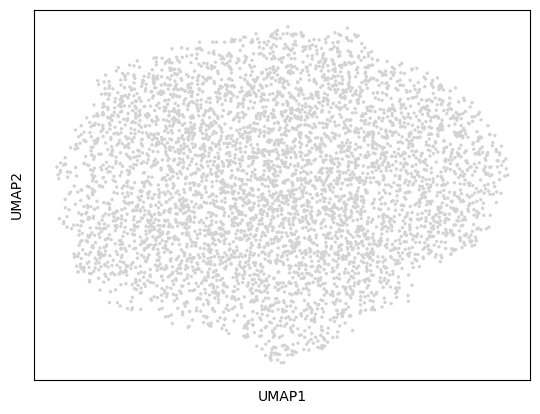

In [97]:
# Plot UMAP
sc.tl.leiden(obj)
sc.tl.umap(obj)
sc.pl.umap(obj)

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


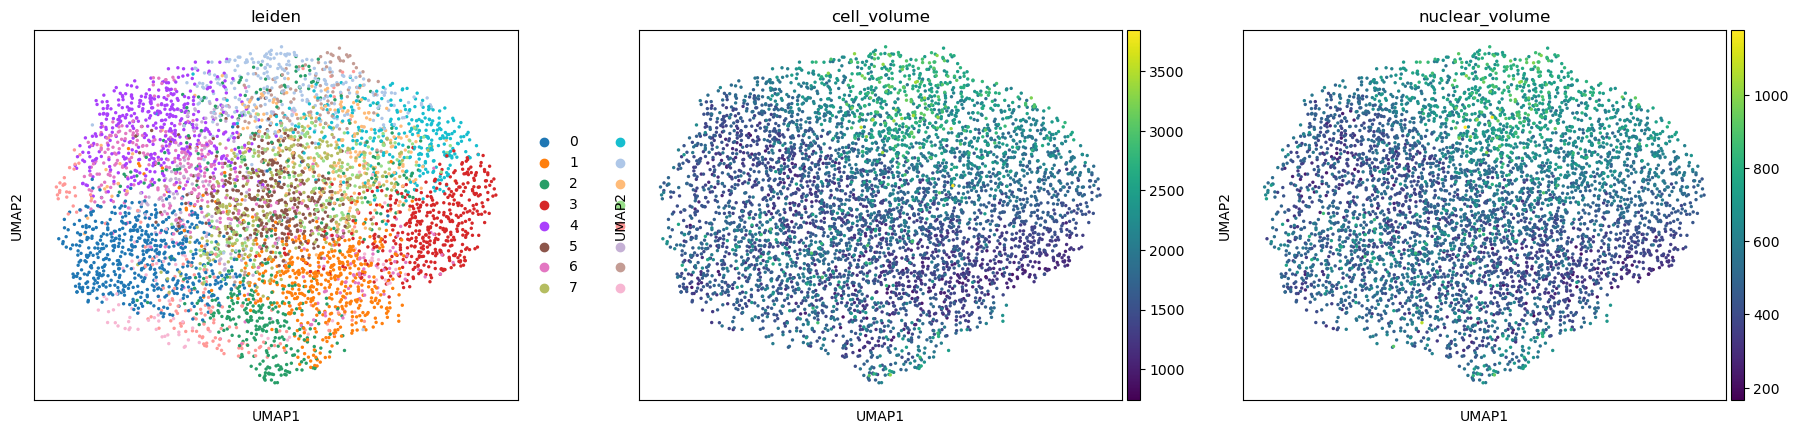

In [98]:
sc.pl.umap(obj, color=['leiden','cell_volume', 'nuclear_volume'])

In [102]:
# Compute diffusion map
sc.tl.diffmap(obj)

# Define root cell
obj.uns['iroot'] = np.flatnonzero(obj.obs['leiden'] == '2')[0]

In [103]:
# Calculate diffusion pseudotime

sc.tl.dpt(obj, n_branchings=0, n_dcs=10)

In [104]:
obj

AnnData object with n_obs × n_vars = 5000 × 8
    obs: 'cell_stage', 'cell_volume', 'nuclear_volume', 'leiden', 'dpt_pseudotime'
    uns: 'neighbors', 'umap', 'cell_stage_colors', 'leiden', 'leiden_colors', 'diffmap_evals', 'iroot'
    obsm: 'X_umap', 'X_diffmap'
    obsp: 'distances', 'connectivities'

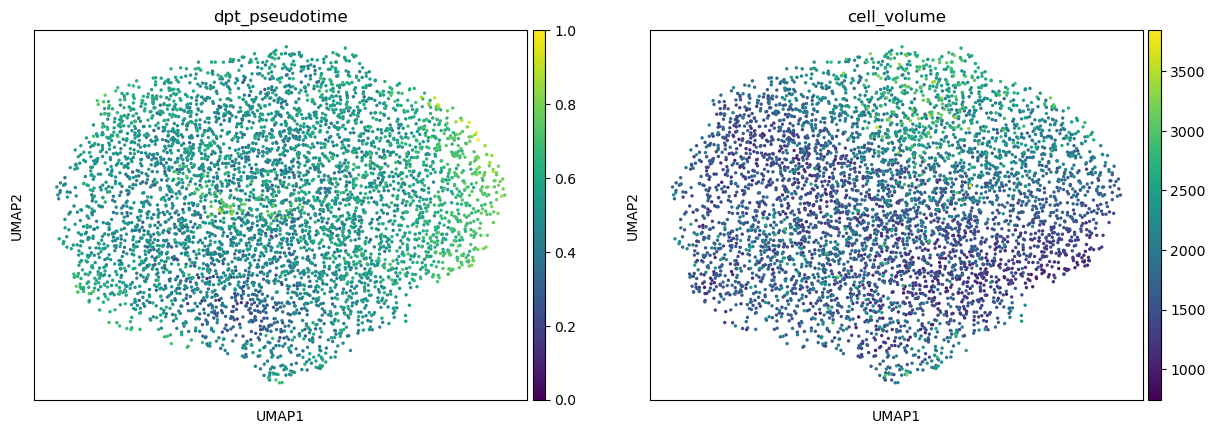

In [105]:
sc.pl.umap(obj, color=['dpt_pseudotime', 'cell_volume'])